<a href="https://colab.research.google.com/github/pseudo-xy/mini-projects-from-learning-path/blob/main/Profile_Fitting_Heuristic_Flow_shop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from typing import List, Tuple

# ==============================
# DATA
# ==============================
# p[k][j] = processing time of job j (0-indexed) at stage k (0-indexed)
p = [
    [3, 1, 6, 3, 5, 4],  # Stage 1 (1 machine)
    [2, 3, 1, 6, 2, 3],  # Stage 2 (2 machines)
    [4, 6, 5, 3, 2, 1]   # Stage 3 (2 machines)
]

n_jobs = 6
n_stages = 3

# Number of machines per stage (parallel machines)
machines_per_stage = [1, 2, 2]

# ==============================
# HELPER: Compute total processing time
# ==============================
def total_processing_time(job):
    return sum(p[k][job] for k in range(n_stages))

# ==============================
# MAIN HEURISTIC
# ==============================
sequence = []
remaining = set(range(n_jobs))

# Stage-level earliest available times (updated after each job)
earliest_available = [0.0] * n_stages

print("Starting Flexible Flow Shop Insertion Heuristic...\n")

# -------------------------------
# Step 1: Job with longest total time
# -------------------------------
total_times = [(total_processing_time(j), -j, j) for j in remaining]  # (time, -index, job)
total_times.sort(reverse=True)  # max time first, then lowest index
first_job = total_times[0][2]
sequence.append(first_job)
remaining.remove(first_job)

# Schedule first job
for k in range(n_stages):
    earliest_available[k] += p[k][first_job]

print(f"Step 1: Job {first_job + 1} (total time = {total_times[0][0]})")

# -------------------------------
# Steps 2 to 6: Insert one by one
# -------------------------------
for pos in range(2, n_jobs + 1):
    best_job = None
    best_npt = float('inf')
    best_departure = None

    for candidate in remaining:
        # Try inserting candidate at current position
        departure = [0.0] * n_stages
        npt = 0.0

        # Stage 1
        departure[0] = max(earliest_available[0], earliest_available[1] if n_stages > 1 else 0) + p[0][candidate]

        # Stage 2 to m-1
        for k in range(1, n_stages - 1):
            arrival = departure[k-1] + p[k][candidate]
            departure[k] = max(arrival, earliest_available[k + 1] if k + 1 < n_stages else 0)

        # Stage m (last stage)
        if n_stages > 1:
            arrival = departure[n_stages-2] + p[n_stages-1][candidate]
            departure[n_stages-1] = max(arrival, 0)  # no downstream

        # Compute NPT per stage
        for k in range(n_stages):
            npt_k = departure[k] - earliest_available[k] - p[k][candidate]
            npt += max(0, npt_k)  # NPT cannot be negative

        # Update best
        if npt < best_npt or (npt == best_npt and (best_job is None or candidate < best_job)):
            best_npt = npt
            best_job = candidate
            best_departure = departure

    # Schedule best job
    sequence.append(best_job)
    remaining.remove(best_job)
    earliest_available = best_departure

    print(f"Step {pos}: Job {best_job + 1} → NPT = {best_npt:.1f}")

# ==============================
# FINAL RESULT
# ==============================
print("\n" + "="*50)
print("FINAL MPS SEQUENCE (1-indexed):")
print(" → ".join(str(job + 1) for job in sequence))
print("="*50)

# Optional: Print Gantt-style departure times
print("\nFinal departure times per stage:")
for k in range(n_stages):
    print(f"  Stage {k+1}: {earliest_available[k]:.1f}")
print(f"Makespan = {earliest_available[-1]:.1f}")

Starting Flexible Flow Shop Insertion Heuristic...

Step 1: Job 3 (total time = 12)
Step 2: Job 2 → NPT = 11.0
Step 3: Job 1 → NPT = 7.0
Step 4: Job 6 → NPT = 10.0
Step 5: Job 4 → NPT = 14.0
Step 6: Job 5 → NPT = 15.0

FINAL MPS SEQUENCE (1-indexed):
3 → 2 → 1 → 6 → 4 → 5

Final departure times per stage:
  Stage 1: 37.0
  Stage 2: 39.0
  Stage 3: 41.0
Makespan = 41.0


Below is the same schedule with a gannt chart

Final Sequence (1-indexed): 3 → 2 → 1 → 6 → 4 → 5
Makespan (stage-3 departure): 41

STAGE 1 – TEXT GANTT CHART
M1A  |JJJ3JJJJ1JJJ6JJ4JJJ5JJ  
     |------------------------
Time → 0 … 22

STAGE 2 – TEXT GANTT CHART
M2A  |      J   J1     JJJ4JJ   
     |--------------------------
M2B  |       J2J    J6J     J5  
     |--------------------------
Time → 0 … 24

STAGE 3 – TEXT GANTT CHART
M3A  |       JJ3JJJJ1J J      J5  
     |----------------------------
M3B  |          JJJ2JJ       J4J  
     |----------------------------
Time → 0 … 26


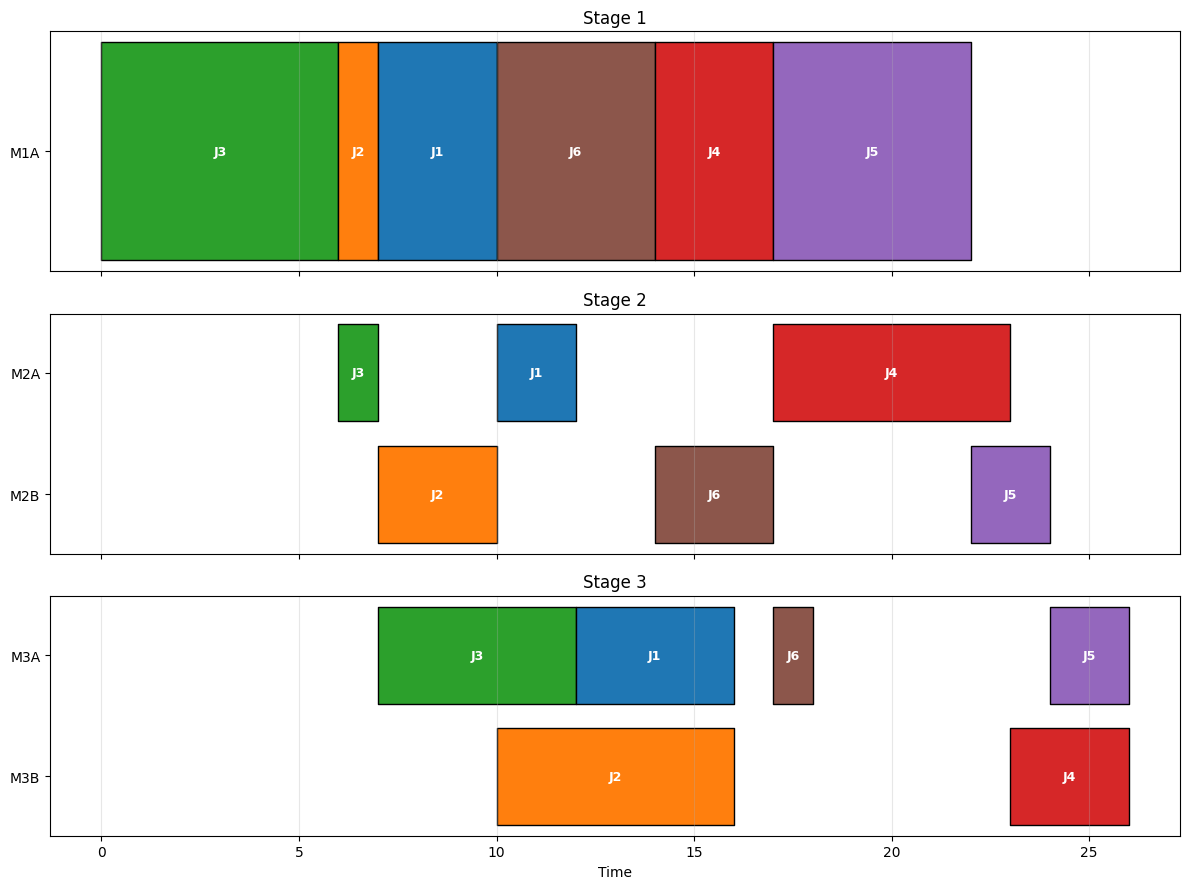

In [ ]:
# ------------------------------------------------------------
#  FLEXIBLE FLOW-SHOP INSERTION HEURISTIC + TEXT GANTT (per stage)
# ------------------------------------------------------------
import matplotlib.pyplot as plt
from collections import defaultdict

# ------------------- 1. INPUT DATA -------------------
p = [
    [3, 1, 6, 3, 5, 4],   # Stage 1
    [2, 3, 1, 6, 2, 3],   # Stage 2
    [4, 6, 5, 3, 2, 1]    # Stage 3
]
n_jobs   = 6
n_stages = 3
machines_per_stage = [1, 2, 2]          # Stage 1: 1, Stage 2: 2, Stage 3: 2

# ------------------- 2. HEURISTIC -------------------
def total_pt(j):
    return sum(p[k][j] for k in range(n_stages))

sequence   = []
remaining  = set(range(n_jobs))
stage_earliest = [0] * n_stages

# ---- Step 1 : longest total time (tie → lowest index)
cands = [(total_pt(j), -j, j) for j in remaining]
cands.sort(reverse=True)
first = cands[0][2]
sequence.append(first)
remaining.remove(first)
for k in range(n_stages):
    stage_earliest[k] += p[k][first]

# ---- Steps 2-6 : insert one by one (min NPT)
for _ in range(1, n_jobs):
    best_job, best_npt, best_dep = None, float('inf'), None
    for cand in remaining:
        dep = [0] * n_stages
        npt = 0
        # Stage 1
        dep[0] = max(stage_earliest[0],
                     stage_earliest[1] if n_stages > 1 else 0) + p[0][cand]
        # Middle stages
        for k in range(1, n_stages-1):
            arr = dep[k-1] + p[k][cand]
            dep[k] = max(arr,
                         stage_earliest[k+1] if k+1 < n_stages else 0)
        # Last stage
        if n_stages > 1:
            arr = dep[n_stages-2] + p[n_stages-1][cand]
            dep[n_stages-1] = max(arr, 0)

        # NPT (never negative)
        for k in range(n_stages):
            npt_k = dep[k] - stage_earliest[k] - p[k][cand]
            npt += max(0, npt_k)

        if npt < best_npt or (npt == best_npt and
                              (best_job is None or cand < best_job)):
            best_npt, best_job, best_dep = npt, cand, dep

    sequence.append(best_job)
    remaining.remove(best_job)
    stage_earliest = best_dep

print("Final Sequence (1-indexed):", " → ".join(str(j+1) for j in sequence))
print("Makespan (stage-3 departure):", stage_earliest[-1])

# ------------------- 3. BUILD FULL SCHEDULE -------------------
schedule = []                     # one entry per operation
machine_avail = [[0] * machines_per_stage[k] for k in range(n_stages)]

for job in sequence:
    prev_finish = 0                # finish time of previous stage
    for k in range(n_stages):
        arrival = prev_finish

        # pick the earliest free machine in this stage
        mach_times = machine_avail[k]
        mach_idx   = mach_times.index(min(mach_times))
        start      = max(arrival, mach_times[mach_idx])
        finish     = start + p[k][job]
        prev_finish = finish

        schedule.append({
            'job'    : job + 1,
            'stage'  : k + 1,
            'machine': f"M{k+1}{chr(65 + mach_idx)}",   # M1A, M2A, M2B …
            'start'  : start,
            'finish' : finish
        })

        machine_avail[k][mach_idx] = finish

# ------------------- 4. TEXT GANTT (one per stage) -------------------
def text_gantt(stage_num):
    ops = [s for s in schedule if s['stage'] == stage_num]
    if not ops:
        return

    machines = sorted({s['machine'] for s in ops})
    max_t    = int(max(s['finish'] for s in ops))   # <-- integer now
    width    = max_t + 2                           # small safety margin

    print("\n" + "="*65)
    print(f"STAGE {stage_num} – TEXT GANTT CHART")
    print("="*65)

    for mach in machines:
        line = [" "] * width
        for op in ops:
            if op['machine'] != mach:
                continue
            s = int(op['start'])
            f = int(op['finish'])
            bar = f"J{op['job']}"
            # draw the bar
            for t in range(s, min(f, width)):
                line[t] = bar[0] if f-s == 1 else bar[0]

            # label in the middle (if room)
            if f-s >= 2:
                mid = (s + f) // 2
                label = bar[:f-s]
                off = (len(label) // 2)
                for i, c in enumerate(label):
                    pos = mid - off + i
                    if 0 <= pos < width:
                        line[pos] = c

        print(f"{mach:4} |{''.join(line)}")
        print("     |" + "-" * min(60, width))

    print(f"Time → 0 … {max_t}")

# print every stage
for st in range(1, n_stages+1):
    text_gantt(st)

# ------------------- 5. (OPTIONAL) MATPLOTLIB GANTT -------------------
def plot_gantt():
    fig, axs = plt.subplots(n_stages, 1,
                            figsize=(12, 3*n_stages),
                            sharex=True)
    if n_stages == 1: axs = [axs]

    colors = plt.cm.tab10.colors

    for st in range(1, n_stages+1):
        ax = axs[st-1]
        ops = [s for s in schedule if s['stage'] == st]
        machs = sorted({s['machine'] for s in ops})

        y_ticks = []
        y_labels = []
        for i, m in enumerate(machs):
            y = len(machs) - i
            y_ticks.append(y)
            y_labels.append(m)

            for op in ops:
                if op['machine'] != m: continue
                ax.broken_barh([(op['start'],
                                 op['finish']-op['start'])],
                               (y-0.4, 0.8),
                               facecolors=colors[(op['job']-1)%10],
                               edgecolor='black')
                mid = op['start'] + (op['finish']-op['start'])/2
                ax.text(mid, y, f'J{op['job']}',
                        ha='center', va='center',
                        color='white', fontweight='bold', fontsize=9)

        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)
        ax.set_title(f"Stage {st}")
        ax.grid(True, axis='x', alpha=0.3)

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

# Uncomment to see the graphical version
plot_gantt()